# Iteratively bias the generative modeling

1) Loading the generated molecules at all temperatures.
2) Select those over some threshold
3) Retrain model

In [1]:
import pandas as pd 
from gpt3forchem.api_wrappers import fine_tune, query_gpt3, extract_prediction
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
from gpt3forchem.output import test_inverse_bandgap
import numpy as np
import time
from fastcore.helpers import save_pickle
plt.style.use(['science', 'nature'])

In [2]:
def load_gaps(filename):
    with open(filename) as f:
        lines = f.readlines()

    smiles_file = filename.replace("_gaps", "")

    smiles_ = []
    with open(smiles_file) as f:
        for line in f.readlines():
            smiles_.append(line.strip())
    

    gaps = []
    smiles = []
    path = []
    for i, line in enumerate(lines):
        try:
            smile, gap = line.split()
            num = int(smile.split('/')[-1])
            gaps.append(float(gap))
            smiles.append(smiles_[num])
            path.append(smile)
        except:
            pass
    temperature = float(filename.split("sets")[-1].split("_")[0])
    return pd.DataFrame({"smiles": smiles, "gap": gaps, "temperature": temperature, "path": path})

In [3]:
res = load_gaps("/Users/kevinmaikjablonka/git/kjappelbaum/gpt3forchem/experiments/for_more_xtb_opt/2022-12-07-15-51-30_smiles_extrapolation_sets1.25_gaps.txt")

In [86]:
res[res['gap'] >14]

,smiles,gap,temperature,path
50,[H]C,17.353074,1.25,2022-12-07-15-51-30_smiles_extrapolation_sets1...


In [10]:
all_files = glob("/Users/kevinmaikjablonka/git/kjappelbaum/gpt3forchem/experiments/for_more_xtb_opt/*_gaps.txt")

In [11]:
all_res = []
for file in all_files:
    all_res.append(load_gaps(file))

FileNotFoundError: [Errno 2] No such file or directory: '/Users/kevinmaikjablonka/git/kjappelbaum/gpt3forchem/experiments/for_more_xtb_opt/2022-12-09-23-20-30_smiles_iteration_1_biased_sets1.5.txt'

In [6]:
all_res = pd.concat(all_res)

ValueError: No objects to concatenate

In [7]:
sns.displot(all_res['gap'])

TypeError: list indices must be integers or slices, not str

In [97]:
all_res[all_res['gap']>3]

,smiles,gap,temperature,path
0,[H]c1nc([H])c2c(c1[H])C([H])([H])N(C(=O)C([H])...,3.212664,0.5,2022-12-07-15-51-30_smiles_random_biased_sets0...
1,[H]OC([H])([H])C([H])([H])C([H])([H])C([H])([H...,10.572196,0.5,2022-12-07-15-51-30_smiles_random_biased_sets0...
4,[H]Oc1c([H])c(C([H])([H])[C@@]([H])(C([H])([H]...,3.632658,0.5,2022-12-07-15-51-30_smiles_random_biased_sets0...
6,[H]c1c([H])c([H])c(C([H])([H])C([H])([H])N([H]...,3.379229,0.5,2022-12-07-15-51-30_smiles_random_biased_sets0...
8,[H]c1c([H])c([H])c(C([H])([H])N([H])C(=O)c2c([...,3.669626,0.5,2022-12-07-15-51-30_smiles_random_biased_sets0...
...,...,...,...,...
35,[H]OC(=O)C([H])([H])C([H])([H])Oc1Sc(Br)c([H])...,3.180736,1.5,2022-12-07-15-51-30_smiles_extrapolation_sets1...
37,[H]O,14.388335,1.5,2022-12-07-15-51-30_smiles_extrapolation_sets1...
38,[H]c1oc(C(C([H])([H])[H])(C([H])([H])[H])C([H]...,4.608166,1.5,2022-12-07-15-51-30_smiles_extrapolation_sets1...
0,[H]c1c([H])c([H])c(C([H])([H])N2C([H])([H])C([...,3.520630,0.0,2022-12-07-15-51-30_smiles_extrapolation_sets0/0


In [92]:
all_res[all_res['gap']>14]['path'].values[1]

'2022-12-07-15-51-30_smiles_extrapolation_sets1.25/8'

In [93]:
all_res[all_res['gap']>14]['smiles'].values[1]

'[H]C'

In [102]:
PROMPT_TEMPLATE_bandgap_inverse = "What is a molecule with a bandgap of {} eV###"
COMPLETION_TEMPLATE_bandgap_inverse = "{}@@@"


def generate_inverse_photoswitch_prompts(
    data: pd.DataFrame, representation: str = "smiles"
) -> pd.DataFrame:
    prompts = []
    completions = []
    smiles = []
    for i, row in data.iterrows():

        prompt = PROMPT_TEMPLATE_bandgap_inverse.format(
            np.round(row["gap"] , 1)
        )

        completion = COMPLETION_TEMPLATE_bandgap_inverse.format(row[representation])
        prompts.append(prompt)
        completions.append(completion)
        smiles.append(row["smiles"])

    prompts = pd.DataFrame(
        {"prompt": prompts, "completion": completions, "SMILES": smiles}
    )

    return prompts

In [113]:
def train_inverse_model(train_prompts, representation):

    train_size = len(train_prompts)

    filename_base = time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime())
    train_filename = f"run_files/{filename_base}_iterative_train_prompts_bandgap_inverse_{representation}_{train_size}.jsonl"

    train_prompts.to_json(train_filename, orient="records", lines=True)

    modelname = fine_tune(train_filename, train_filename, "ada")
    return modelname, train_filename

In [116]:
def test_inverse_model(
    modelname,
    test_prompts,
    df_train,
    max_tokens: int = 250,
    temperatures=None,
    representation="SMILES",
):
    temperatures = temperatures or [0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5]
    train_smiles = df_train["SMILES"].to_list()
    results = []
    for temperature in temperatures:
        try:
            print(f"Testing temperature {temperature} for {representation}")
            result = test_inverse_bandgap(
                test_prompts,
                modelname,
                train_smiles=train_smiles,
                temperature=temperature,
                max_tokens=max_tokens,
                representation=representation,
            )

            results.append(result)
        except Exception as e:
            print(e)
            pass

    return results

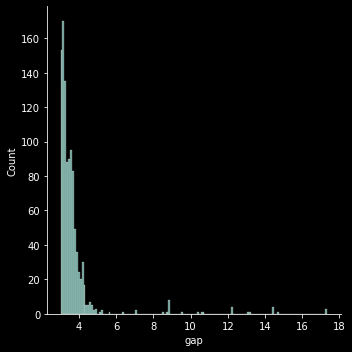

In [100]:
sns.displot(all_res[all_res['gap']>3]['gap'])

In [103]:
large_gap = all_res[all_res['gap']>3]

In [104]:
large_gap_prompts = generate_inverse_photoswitch_prompts(large_gap)

In [105]:
len(large_gap_prompts)

1052

In [111]:
random_bandgaps = np.random.normal(4.0, 0.2, size=len(large_gap_prompts)) 
test_set_random_biased = large_gap.copy()
test_set_random_biased['gap'] = random_bandgaps
filename_base = time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime())

test_prompts_random_biased = generate_inverse_photoswitch_prompts(test_set_random_biased)
valid_filename_random_biased = f"run_files/{filename_base}_iterative_valid_prompts_bandgap_inverse_smiles_random_biased.jsonl"
test_prompts_random_biased.to_json(valid_filename_random_biased, orient="records", lines=True)

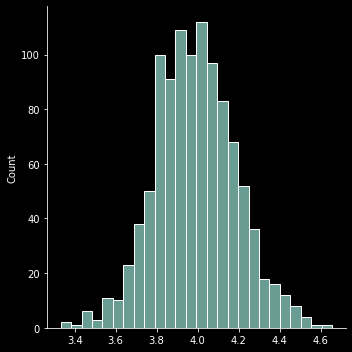

In [112]:
sns.displot(random_bandgaps)

In [114]:
train_inverse_model(large_gap_prompts, "smiles")

Traceback (most recent call last):
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/bin/openai", line 8, in <module>
    sys.exit(main())
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/_openai_scripts.py", line 63, in main
    args.func(args)
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/cli.py", line 545, in sync
    resp = openai.wandb_logger.WandbLogger.sync(
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 74, in sync
    fine_tune_logged = [
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 75, in <listcomp>
    cls._log_fine_tune(
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 125, in _log_fine_tune
    wandb_run = cls._get_wandb_run(run_path)
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/pyth

('ada:ft-lsmoepfl-2022-12-09-22-38-37',
 'run_files/2022-12-09-23-22-11_iterative_train_prompts_bandgap_inverse_smiles_1052.jsonl')

In [117]:
iteration_1_test_results = test_inverse_model("ada:ft-lsmoepfl-2022-12-09-22-38-37", test_prompts_random_biased, large_gap_prompts)

Testing temperature 0 for SMILES


2022-12-09 23:51:25.966 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:931 - Got predictions, example: [H]c1c([H])c([H])c(C([H])([H])N([H])C(=O)C([H])([H])c2c([H])c([H])c(C([H])([H])[H])c([H])c2[H])c([H])c1[H]
2022-12-09 23:51:25.966 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:942 - Loaded predictions. Example: [H]c1c([H])c([H])c(C([H])([H])N([H])C(=O)C([H])([H])c2c([H])c([H])c(C([H])([H])[H])c([H])c2[H])c([H])c1[H]
2022-12-09 23:51:26.066 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:953 - Calculating Frechet ChemNet distance for 1052 samples
2022-12-09 23:51:26.120 | INFO     | gpt3forchem.output:_load_chemnet:218 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
2022-12-09 23:51:27.013489: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-09 23:51:34.635 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:962 - Computed frechet score: (52.243671484551875, 2

Testing temperature 0.25 for SMILES


2022-12-09 23:58:24.856 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:931 - Got predictions, example: [H]c1c([H])c([H])c(C([H])([H])N([H])C(=O)C([H])([H])c2c([H])c([H])c(C([H])([H])[H])c([H])c2[H])c([H])c1[H]
2022-12-09 23:58:24.856 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:942 - Loaded predictions. Example: [H]c1c([H])c([H])c(C([H])([H])N([H])C(=O)C([H])([H])c2c([H])c([H])c(C([H])([H])[H])c([H])c2[H])c([H])c1[H]
2022-12-09 23:58:24.965 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:953 - Calculating Frechet ChemNet distance for 1038 samples
2022-12-09 23:58:25.034 | INFO     | gpt3forchem.output:_load_chemnet:218 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
2022-12-09 23:58:32.549 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:962 - Computed frechet score: (40.322944841288816, 0.00031448034863049)
2022-12-09 23:58:35.424 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:973 - Computed KL div sc

Testing temperature 0.5 for SMILES


2022-12-10 00:04:55.654 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:931 - Got predictions, example: [H]c1nc([H])c(C([H])([H])N([H])C(=O)C([H])([H])c2c([H])c([H])c([H])c([H])c2C([H])([H])[H])c([H])c1[H]
2022-12-10 00:04:55.655 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:942 - Loaded predictions. Example: [H]c1nc([H])c(C([H])([H])N([H])C(=O)C([H])([H])c2c([H])c([H])c([H])c([H])c2C([H])([H])[H])c([H])c1[H]
2022-12-10 00:04:55.794 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:953 - Calculating Frechet ChemNet distance for 1020 samples
2022-12-10 00:04:55.841 | INFO     | gpt3forchem.output:_load_chemnet:218 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
2022-12-10 00:05:03.635 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:962 - Computed frechet score: (18.313737511321456, 0.025661909624882816)
2022-12-10 00:05:07.020 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:973 - Computed KL div score: 0.73

Testing temperature 0.75 for SMILES


2022-12-10 00:11:29.036 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:931 - Got predictions, example: [H]c1c([H])c([H])c(S(=O)(=O)N([H])C([H])([H])C([H])([H])C([H])([H])N2C(=O)N(C([H])([H])[H])C([H])([H])C([H])([H])C2([H])[H])c([H])c1[H]
2022-12-10 00:11:29.036 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:942 - Loaded predictions. Example: [H]c1c([H])c([H])c(S(=O)(=O)N([H])C([H])([H])C([H])([H])C([H])([H])N2C(=O)N(C([H])([H])[H])C([H])([H])C([H])([H])C2([H])[H])c([H])c1[H]
2022-12-10 00:11:29.201 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:953 - Calculating Frechet ChemNet distance for 976 samples
2022-12-10 00:11:29.264 | INFO     | gpt3forchem.output:_load_chemnet:218 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
2022-12-10 00:11:36.548 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:962 - Computed frechet score: (6.11185915362865, 0.2945307607073991)
2022-12-10 00:11:40.694 | DEBUG    | gpt3forche

Testing temperature 1.0 for SMILES


2022-12-10 00:18:06.130 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:931 - Got predictions, example: [H]c1nc(N([H])[H])c([H])c(C([H])([H])[C@@]2([H])C([H])([H])[C@]([H])(C([H])([H])N([H])C(=O)C([H])([H])[C@]([H])(C([H])([H])[H])C2([H])[H])C([H])([H])C2([H])[H])c1[H]
2022-12-10 00:18:06.131 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:942 - Loaded predictions. Example: [H]c1nc(N([H])[H])c([H])c(C([H])([H])[C@@]2([H])C([H])([H])[C@]([H])(C([H])([H])N([H])C(=O)C([H])([H])[C@]([H])(C([H])([H])[H])C2([H])[H])C([H])([H])C2([H])[H])c1[H]
2022-12-10 00:18:06.364 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:953 - Calculating Frechet ChemNet distance for 790 samples
2022-12-10 00:18:06.432 | INFO     | gpt3forchem.output:_load_chemnet:218 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
2022-12-10 00:18:14.026 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:962 - Computed frechet score: (3.1105618472356227, 0.536

Testing temperature 1.25 for SMILES


2022-12-10 00:25:13.654 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:931 - Got predictions, example: [H]FK&&
2022-12-10 00:25:13.656 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:942 - Loaded predictions. Example: [H]FK&&
2022-12-10 00:25:13.981 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:953 - Calculating Frechet ChemNet distance for 469 samples
2022-12-10 00:25:14.038 | INFO     | gpt3forchem.output:_load_chemnet:218 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
2022-12-10 00:25:21.383 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:962 - Computed frechet score: (4.715856152336599, 0.3893910266049677)
2022-12-10 00:25:23.810 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:973 - Computed KL div score: 0.9282424481250438


Testing temperature 1.5 for SMILES
That model is still being loaded. Please try again shortly.


In [119]:
save_pickle(f"run_files/{filename_base}-iteration_1_results_extrapolation_smiles_more.pkl", iteration_1_test_results)

In [120]:
smiles_random_biased_sets = []

for res in iteration_1_test_results:
    result = {}
    result["temperature"] = res["meta"]["temperature"]
    result["smiles"] = set(
        res["predictions"][res["valid_smiles"]]
    )
    result['original_prediction_indices'] = [i for i, x in enumerate(res["predictions"]) if x in result['smiles']]
    result['expected'] = [res['expectations'][i] for i in result['original_prediction_indices']]
    smiles_random_biased_sets.append(result)

for res in smiles_random_biased_sets:
    temp = res["temperature"]
    smiles_set = res["smiles"]
    with open(f"for_more_xtb_opt/{filename_base}_smiles_iteration_1_biased_sets{temp}.txt", "w") as f:
        for i, smiles in enumerate(smiles_set):
            if i != len(smiles_set) - 1:
                f.write(smiles + "\n")
            else:
                f.write(smiles)

In [133]:
biased_gap_files = glob("/Users/kevinmaikjablonka/git/kjappelbaum/gpt3forchem/experiments/for_more_xtb_opt/*_smiles_random_biased_sets*_gaps.txt")

In [134]:
biased_gap_res = []
for file in biased_gap_files:
    biased_gap_res.append(load_gaps(file))

In [136]:
biased_gap_res = pd.concat(biased_gap_res)

<AxesSubplot:xlabel='gap', ylabel='Density'>

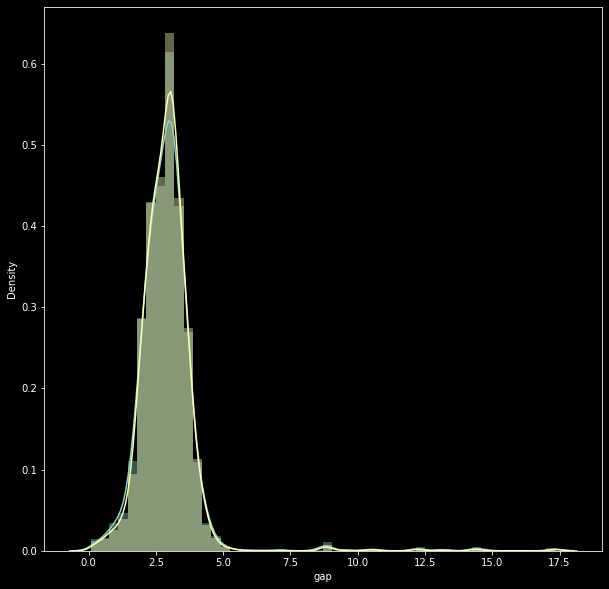

In [165]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.distplot(all_res[all_res['temperature']>0]['gap'], ax=ax)
sns.distplot(biased_gap_res[biased_gap_res['temperature']>0]['gap'], ax=ax)


In [155]:
biased_gap_res[biased_gap_res['temperature']>1.0]['gap'].mean()

5.606668254252824

In [156]:
all_res[all_res['temperature']>1.0]['gap'].mean()

3.5713476977488487

In [158]:
zeroth_and_first = pd.concat([all_res, biased_gap_res])

In [159]:
zeroth_and_first_large_gap = zeroth_and_first[zeroth_and_first['gap']>4]

In [160]:
zeroth_and_first_large_gap_prompts = generate_inverse_photoswitch_prompts(zeroth_and_first_large_gap)

In [162]:
random_bandgaps_zeroth_first = np.random.normal(4.5, 0.2, size=len(zeroth_and_first_large_gap)) 
test_set_zeroth_and_first_large_gap = zeroth_and_first_large_gap.copy()
test_set_zeroth_and_first_large_gap['gap'] = random_bandgaps_zeroth_first
filename_base = time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime())

test_set_zeroth_and_first_large_gap_prompts = generate_inverse_photoswitch_prompts(test_set_zeroth_and_first_large_gap)
valid_filename_random_biased_1 = f"run_files/{filename_base}_iterative_2_valid_prompts_bandgap_inverse_smiles_random_biased.jsonl"
test_set_zeroth_and_first_large_gap_prompts.to_json(valid_filename_random_biased_1, orient="records", lines=True)

In [163]:
len(zeroth_and_first_large_gap_prompts)

243

In [164]:
train_inverse_model(zeroth_and_first_large_gap_prompts, "smiles")

Traceback (most recent call last):
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/bin/openai", line 8, in <module>
    sys.exit(main())
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/_openai_scripts.py", line 63, in main
    args.func(args)
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/cli.py", line 545, in sync
    resp = openai.wandb_logger.WandbLogger.sync(
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 74, in sync
    fine_tune_logged = [
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 75, in <listcomp>
    cls._log_fine_tune(
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 125, in _log_fine_tune
    wandb_run = cls._get_wandb_run(run_path)
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/pyth

('ada:ft-lsmoepfl-2022-12-11-22-58-26',
 'run_files/2022-12-11-23-55-11_iterative_train_prompts_bandgap_inverse_smiles_243.jsonl')

In [166]:
iteration_2_test_results = test_inverse_model("ada:ft-lsmoepfl-2022-12-11-22-58-26", test_set_zeroth_and_first_large_gap_prompts, zeroth_and_first_large_gap_prompts)

Testing temperature 0 for SMILES


2022-12-12 08:22:17.095 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:931 - Got predictions, example: [H]c1c([H])c([H])c(C([H])([H])N([H])C(=O)C([H])([H])c2c([H])c([H])c([H])c([H])c2[H])c([H])c1[H]
2022-12-12 08:22:17.100 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:942 - Loaded predictions. Example: [H]c1c([H])c([H])c(C([H])([H])N([H])C(=O)C([H])([H])c2c([H])c([H])c([H])c([H])c2[H])c([H])c1[H]
2022-12-12 08:22:17.198 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:953 - Calculating Frechet ChemNet distance for 237 samples
2022-12-12 08:22:17.323 | INFO     | gpt3forchem.output:_load_chemnet:218 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
2022-12-12 08:22:26.081 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:962 - Computed frechet score: (31.84458936861148, 0.001714013000883716)
2022-12-12 08:22:26.536 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:973 - Computed KL div score: nan


Testing temperature 0.25 for SMILES


2022-12-12 08:23:56.230 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:931 - Got predictions, example: [H]c1c([H])c([H])c(C([H])([H])N([H])C(=O)C([H])([H])c2c([H])c([H])c(C([H])([H])[H])c([H])c2[H])c([H])c1[H]
2022-12-12 08:23:56.232 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:942 - Loaded predictions. Example: [H]c1c([H])c([H])c(C([H])([H])N([H])C(=O)C([H])([H])c2c([H])c([H])c(C([H])([H])[H])c([H])c2[H])c([H])c1[H]
2022-12-12 08:23:56.280 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:953 - Calculating Frechet ChemNet distance for 161 samples
2022-12-12 08:23:56.361 | INFO     | gpt3forchem.output:_load_chemnet:218 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
2022-12-12 08:24:04.350 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:962 - Computed frechet score: (20.77437011399143, 0.015687767306168214)
2022-12-12 08:24:04.718 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:973 - Computed KL div sco

Testing temperature 0.5 for SMILES


2022-12-12 08:25:35.124 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:931 - Got predictions, example: [H]c1c([H])c([H])c(C([H])([H])N([H])C(=O)C([H])([H])[C@@]2([H])C([H])([H])C([H])([H])C2([H])[H])c([H])c1[H]
2022-12-12 08:25:35.128 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:942 - Loaded predictions. Example: [H]c1c([H])c([H])c(C([H])([H])N([H])C(=O)C([H])([H])[C@@]2([H])C([H])([H])C([H])([H])C2([H])[H])c([H])c1[H]
2022-12-12 08:25:35.170 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:953 - Calculating Frechet ChemNet distance for 201 samples
2022-12-12 08:25:35.238 | INFO     | gpt3forchem.output:_load_chemnet:218 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
2022-12-12 08:25:42.750 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:962 - Computed frechet score: (13.575678695334389, 0.066195967018418)
2022-12-12 08:25:43.236 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:973 - Computed KL div sco

Testing temperature 0.75 for SMILES


2022-12-12 08:27:13.510 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:931 - Got predictions, example: [H]O[C@]1([H])[C@@]([H])(C([H])([H])[H])O[C@]([H])(C([H])([H])[H])[C@]1([H])O[H]
2022-12-12 08:27:13.511 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:942 - Loaded predictions. Example: [H]O[C@]1([H])[C@@]([H])(C([H])([H])[H])O[C@]([H])(C([H])([H])[H])[C@]1([H])O[H]
2022-12-12 08:27:13.554 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:953 - Calculating Frechet ChemNet distance for 202 samples
2022-12-12 08:27:13.664 | INFO     | gpt3forchem.output:_load_chemnet:218 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
2022-12-12 08:28:18.824 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:962 - Computed frechet score: (6.672777954115432, 0.2632751513548374)
2022-12-12 08:28:19.416 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:973 - Computed KL div score: 0.8286259342095301


Testing temperature 1.0 for SMILES


2022-12-12 08:29:50.185 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:931 - Got predictions, example: [H]OC(=O)C1(C([H])([H])[H])C([H])([H])C([H])([H])C1([H])[H]
2022-12-12 08:29:50.186 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:942 - Loaded predictions. Example: [H]OC(=O)C1(C([H])([H])[H])C([H])([H])C([H])([H])C1([H])[H]
2022-12-12 08:29:50.241 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:953 - Calculating Frechet ChemNet distance for 165 samples
2022-12-12 08:29:50.286 | INFO     | gpt3forchem.output:_load_chemnet:218 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
2022-12-12 08:29:56.631 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:962 - Computed frechet score: (6.546297422044418, 0.2700199363412138)
2022-12-12 08:29:57.139 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:973 - Computed KL div score: 0.9498956868422057


Testing temperature 1.25 for SMILES


2022-12-12 08:31:29.053 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:931 - Got predictions, example: [H]OC(=O)C([H])
2022-12-12 08:31:29.053 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:942 - Loaded predictions. Example: [H]OC(=O)C([H])
2022-12-12 08:31:29.121 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:953 - Calculating Frechet ChemNet distance for 92 samples
2022-12-12 08:31:29.180 | INFO     | gpt3forchem.output:_load_chemnet:218 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
2022-12-12 08:31:35.741 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:962 - Computed frechet score: (9.861801534423954, 0.139128083392208)
2022-12-12 08:31:36.162 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:973 - Computed KL div score: 0.7808783289468003


Testing temperature 1.5 for SMILES


2022-12-12 08:33:08.307 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:931 - Got predictions, example: [H]O[C@]1([H])[C@@]1(C([H])([H])[H])O[
2022-12-12 08:33:08.307 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:942 - Loaded predictions. Example: [H]O[C@]1([H])[C@@]1(C([H])([H])[H])O[
2022-12-12 08:33:08.385 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:953 - Calculating Frechet ChemNet distance for 31 samples
2022-12-12 08:33:08.469 | INFO     | gpt3forchem.output:_load_chemnet:218 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
2022-12-12 08:33:17.907 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:962 - Computed frechet score: (24.80341578918178, 0.007008138532091136)
2022-12-12 08:33:18.244 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:973 - Computed KL div score: 0.5386800388542898


In [167]:
save_pickle(f"run_files/{filename_base}-iteration_2_results_extrapolation_smiles_more.pkl", iteration_2_test_results)

In [168]:
smiles_random_biased_sets_2 = []

for res in iteration_2_test_results:
    result = {}
    result["temperature"] = res["meta"]["temperature"]
    result["smiles"] = set(
        res["predictions"][res["valid_smiles"]]
    )
    result['original_prediction_indices'] = [i for i, x in enumerate(res["predictions"]) if x in result['smiles']]
    result['expected'] = [res['expectations'][i] for i in result['original_prediction_indices']]
    smiles_random_biased_sets_2.append(result)

for res in smiles_random_biased_sets_2:
    temp = res["temperature"]
    smiles_set = res["smiles"]
    with open(f"for_more_xtb_opt/{filename_base}_smiles_iteration_2_biased_sets{temp}.txt", "w") as f:
        for i, smiles in enumerate(smiles_set):
            if i != len(smiles_set) - 1:
                f.write(smiles + "\n")
            else:
                f.write(smiles)